<a href="https://colab.research.google.com/github/finiteautomata/hatespeech-classification/blob/main/notebooks/Contextualized_Hate_Speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detección contextualizada de discurso de odio

En esta notebook, vamos a usar el dataset de discurso de odio contextualizado para entrenar un clasificador estado del arte basado en BERT


En primer lugar, instalamos dependencias. Más que nada, vamos a usar [huggingface/transformers](https://huggingface.co/transformers), librería del estado del arte para NLP.

In [1]:
!pip install transformers datasets huggingface_hub ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 13.9 MB/s 
     |████████████████████████████████| 451 kB 80.1 MB/s 
     |████████████████████████████████| 182 kB 68.5 MB/s 
     |████████████████████████████████| 7.6 MB 70.7 MB/s 
     |████████████████████████████████| 212 kB 72.3 MB/s 
     |████████████████████████████████| 115 kB 90.3 MB/s 
     |████████████████████████████████| 127 kB 84.8 MB/s 
     |████████████████████████████████| 793 kB 70.5 MB/s 
     |████████████████████████████████| 1.6 MB 75.3 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11649 sha256=10c0495049d7ca9e9d4d0ec26bf51b1c6689ac6875a8512158d1bd115abf00b0
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

Nos logueamos en huggingface. Esto es necesario ya que el dataset es privado por ahora :-)

Van a tener que generar un token en la página correspondiente

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


Cargamos el dataset

In [1]:
from datasets import load_dataset

ds = load_dataset("piubamas/contextualized_hate_speech")

  0%|          | 0/3 [00:00<?, ?it/s]

Veamos qué tiene

In [2]:
ds

DatasetDict({
    test: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 11343
    })
    dev: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 9106
    })
    train: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 36420
    })
})

El dataset ya está partido en 3 splits (train, test, dev) y tiene las columnas 
['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL']

¿Y algún ejemplo?

In [4]:
ds["train"][0]

{'id': 343726,
 'title': 'Video: salió de la cárcel por el coronavirus y murió de un tiro el mismo día al festejar su libertad',
 'text': '@usuario Uno menos',
 'context_tweet': 'Video: salió de la cárcel por el coronavirus y murió de un tiro el mismo día al festejar su libertad https://t.co/UrJGRAdEvD',
 'HATEFUL': 1,
 'body': 'Un hombre de 46 años, que cumplía una condena en prisión y fue puesto en libertad por el coronavirus, murió el mismo día que dejó la cárcel baleado por un primo, durante los "festejos" por dejar la prisión.\n\nSari Salem Wardat, de 46 años, recibió un disparo desde atrás en un aparente accidente mientras caminaba hacia miembros de la familia y vecinos que se habían reunido para darle la bienvenida a su casa, en Jordania.\n\nUn video que circuló en las redes sociales \u200bmuestra a Sari llegando a su casa en un auto azul rodeado de tiros de "celebración". El primo se acerca de inmediato a Sari, que sostiene una pistola y la apunta hacia el cielo.\n\nEl detenido

In [19]:
ds["train"][1041]

{'id': 361500,
 'title': 'Eduardo Costantini y Elina Fernández mostraron la intimidad de su luna de miel: "Ella no me deja tomar una copa de vino"',
 'text': '@usuario Llegar a viejo y ser tan pelotudo. Garchate cuánta trola quieras. Pero hacerte el novio con una no da',
 'context_tweet': 'Eduardo Costantini y Elina Fernández mostraron la intimidad de su luna de miel: “Ella no me deja tomar una copa de vino” https://t.co/NvBhExZEnk',
 'HATEFUL': 1,
 'body': 'Eduardo Costantini y Elina fernandez, de luna de miel en Bariloche (Fotos: Instagram)\n\nEs una escena por demás cotidiana, de una pareja cualquiera que disfruta de su primer viaje como recién casados. Y ella, pese al desconcierto inicial de él, decide compartirlo con sus seguidores en las redes sociales. Pero todo esto adquiere otra dimensión cuando se revela que los protagonistas son Eduardo Costantini y Elina Fernández, cuya relación sentimental fue puesta en duda -de un modo escandaloso- por Ananá Ferreira, quien habló de un "p

## Modelo de clasificación

Vamos a intentar predecir con un clasificador qué características son atacadas en un tweet. Es decir, nuestro algoritmo va a tomar como entrada un contexto (e.g. "China prohibió el consumo de carne de perro"), y un texto ("Son unos salvajes y se merecen el COVID") e intentará predecir las características atacadas (en este caso, RACISMO)

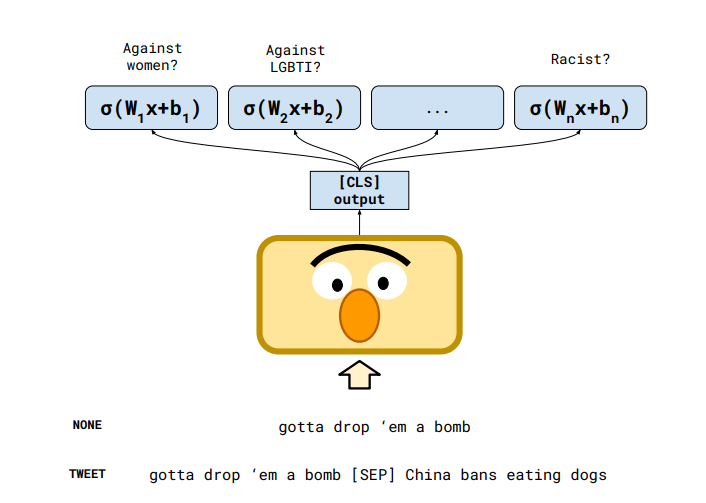

Vamos a cargar un modelo "BETO" (Bert en Español) para clasificación múltiple (predecir 9 características al mismo tiempo)

También cargamos un tokenizador, que es lo que convierte nuestro texto en "tokens" (podemos pensarlo como pedacitos de palabras/morfemas)

In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "dccuchile/bert-base-spanish-wwm-cased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=9, #9 labels: Calls + características
    problem_type="multi_label_classification")

model.config.id2label = dict(zip([str(k) for k in range(10)], id2label))
model.config.label2id = {v:int(k) for k, v in model.config.id2label.items()}

tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-cased/snapshots/56a7647b957a4230fc3f80dafbe80f2ba9b0de73/config.json
Model config BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings"

Tokenizamos el texto. Acá convertimos contexto y texto en un único string, separado por un caracter especial llamado `[SEP]`

In [37]:
tokenizer.model_max_length = 256

def tokenize(ex):
    return tokenizer(ex["text"], ex["context_tweet"], truncation="longest_first")

tokenized_ds = ds.map(tokenize)

  0%|          | 0/36420 [00:00<?, ?ex/s]

In [38]:
tokenized_ds

DatasetDict({
    test: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11343
    })
    dev: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9106
    })
    train: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 36420
    })
})

Ahora tenemos `input_ids` y otros que son secuencias de números (correspondientes a los tokens) que vamos a meter en nuestro clasificador.

Próximo paso: decimos qué etiquetas queremos predecir. Para eso, creamos una nueva columna llamada `labels`, que va a contener en nuestro caso las características a predecir

In [39]:
from pandas.core.arrays.sparse import dtype
import torch

id2label = ['CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL']

label2id = {v:k for k, v in enumerate(id2label)}

def set_labels(example):
    return {"labels": torch.Tensor([float(example[cat]) for cat in id2label])}

formatted_ds = tokenized_ds.map(set_labels)
formatted_ds.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', "labels"])

  0%|          | 0/36420 [00:00<?, ?ex/s]

Y listo! Ahora entrenamos.

In [42]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred, **kwargs):
    """
    Esta función calcula las métricas f1 para cada característica
    """
    preds = (pred.predictions > 0)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    
    ret = {}

    ret["Macro F1"] = f1.mean()
    ret["Macro Precision"] = precision.mean()
    ret["Macro Recall"] = recall.mean()

    for i, label in enumerate(id2label):
        ret[label+"_f1"] = f1[i]
    return ret


# Este "recolector" de datos hace que los distintos lotes que 
# procesa BERT tengan todos el mismo largo. Para eso, rellena
# con `padding`.
data_collator = DataCollatorWithPadding(tokenizer, padding="longest") 

# Argumentos varios de entrenamiento
# - Tamaño de lote
# - Cada cuánto evaluamos los resultados
# - Si elegimos el mejor resultado al final de cada evaluación
# - otros
train_args = TrainingArguments(
    output_dir="hs_clf",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    learning_rate=4e-5,
    group_by_length=True,
    save_strategy="epoch",
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_Macro F1",
)

trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=formatted_ds["train"],
    eval_dataset=formatted_ds["dev"],
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACISM, CALLS. If APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACISM, CALLS are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.o

Epoch,Training Loss,Validation Loss,Macro f1,Macro precision,Macro recall,Calls F1,Women F1,Lgbti F1,Racism F1,Class F1,Politics F1,Disabled F1,Appearance F1,Criminal F1
1,0.068500,0.058121,0.535785,0.654929,0.470845,0.596059,0.325581,0.544747,0.647520,0.398268,0.604278,0.321168,0.655502,0.728938
2,0.043700,0.048577,0.577243,0.794400,0.472061,0.677346,0.438095,0.474747,0.619195,0.369942,0.598802,0.507692,0.710921,0.798450
3,0.024600,0.046391,0.644691,0.729996,0.582566,0.714588,0.508197,0.578723,0.693824,0.478469,0.675192,0.588235,0.767347,0.797642


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACISM, CALLS. If APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACISM, CALLS are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9106
  Batch size = 32
Saving model checkpoint to hs_clf/checkpoint-1139
Configuration saved in hs_clf/checkpoint-1139/config.json
Model weights saved in hs_clf/checkpoint-1139/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACIS

TrainOutput(global_step=3417, training_loss=0.05937679392362778, metrics={'train_runtime': 520.4476, 'train_samples_per_second': 209.935, 'train_steps_per_second': 6.566, 'total_flos': 4208709387541824.0, 'train_loss': 0.05937679392362778, 'epoch': 3.0})

In [43]:
trainer.evaluate(formatted_ds["test"])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACISM, CALLS. If APPEARANCE, title, HATEFUL, POLITICS, DISABLED, text, WOMEN, id, body, CLASS, context_tweet, LGBTI, CRIMINAL, RACISM, CALLS are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 11343
  Batch size = 32


{'eval_loss': 0.058303531259298325,
 'eval_Macro F1': 0.5539158035789873,
 'eval_Macro Precision': 0.6738579325155638,
 'eval_Macro Recall': 0.47588682263614346,
 'eval_CALLS_f1': 0.6653771760154739,
 'eval_WOMEN_f1': 0.3705463182897862,
 'eval_LGBTI_f1': 0.42,
 'eval_RACISM_f1': 0.6774566473988439,
 'eval_CLASS_f1': 0.3755458515283843,
 'eval_POLITICS_f1': 0.602910602910603,
 'eval_DISABLED_f1': 0.5087719298245613,
 'eval_APPEARANCE_f1': 0.723529411764706,
 'eval_CRIMINAL_f1': 0.6411042944785276,
 'eval_runtime': 22.1824,
 'eval_samples_per_second': 511.351,
 'eval_steps_per_second': 16.004,
 'epoch': 3.0}

## Ejemplos

In [77]:
tokenizer.encode_plus("Putos", "de mierda")

{'input_ids': [4, 4446, 1158, 5, 1008, 3383, 5], 'token_type_ids': [0, 0, 0, 0, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [78]:
def predict(*args):
    encoding = tokenizer.encode_plus(*args)

    inputs = {
        k:torch.LongTensor(encoding[k]).reshape(1, -1).to("cuda") for k in {"input_ids", "attention_mask", "token_type_ids"}
    }

    output = model.forward(
        **inputs
    )

    chars = list(zip(label2id, list(output.logits[0].detach().cpu().numpy() > 0)))

    return [char for char, pred in chars if pred]

In [79]:

predict("Hay que matarlos a todos", "La selección alemana se niega a cantar el himno en Qatar")

['CALLS', 'RACISM']

In [80]:

predict("Hay que matarlos a todos", "Invasión de zarigüeyas en Cañuelas")

['CALLS']

In [81]:
predict("Hay que matarlos a todos", "Fuga de presos en Devoto: hay cinco heridos entre los guardiacárceles")

['CALLS', 'CRIMINAL']